## Abstract: This notebook will be used for the capstone project


In [1]:
import os
import io
import shutil

import pandas as pd
import numpy as np
from scipy.stats import mode

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import base64

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Utlity functios


In [2]:
class FileWriter:
    def __init__(self, filename):
        self.filename = filename

    def __enter__(self):
        self.file = open(self.filename, 'a')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.file.close()

    def append_to_file(self, text):
        self.file.write(text + '\n')

In [3]:
def Write_Readme_file():
    
    # names of the files to be concatenated
    file1 = "README_Org.md"
    file2 = "output.md"

    # name of the output file
    output_file = "README.md"

    # open the output file in write mode
    with open(output_file, "w") as outfile:
        # open the first file in read mode
        with open(file1, "r") as infile:
            # write its contents to the output file
            content = infile.read()
            # print(f"Content of {file1}:")
            # print(content)
            outfile.write(content)

        # write a newline to separate the contents of the two files
        outfile.write("\n")

        # open the second file in read mode
        with open(file2, "r") as infile:
            # write its contents to the output file
            content = infile.read()
            # print(f"Content of {file2}:")
            # print(content)
            outfile.write(content)
    outfile.close()
    

In [4]:

class Visualize_process_dataset:
    def __init__(self, Image_fiel_path,csv_file_path,Org_csv_file,Balaced_csv_file, corrupt_dir, output_csv):
        
        self.df = pd.read_csv(self.Org_csv_file)
        self.corrupt_dir = corrupt_dir
        self.output_csv = output_csv
        self.Org_csv_file = Org_csv_file
        self.Image_fiel_path = Image_fiel_path

    def Rename_colum(self,Nem_colum_name):
        self.df.rename(columns=Nem_colum_name, inplace=True) # rename column name


A balanced dataset for image categorization means that there are roughly equal numbers of images for each class or category in the dataset. You can check the balance of your dataset by counting the number of instances of each class




### Examine the dataset and balance the dataset.

In [5]:
class BlanceDataste:
    def __init__(self, df, output_csv, featuresList):
        self.df = df
        self.output_csv = output_csv
        self.featuresList = featuresList
        print(self.featuresList)

    def process_Data(self):
        try:
            # Separate features and target variables
             features = self.df.drop(self.featuresList, axis=1)  # Replace with your actual column names
             targets = self.df[self.featuresList]  # Replace with your actual column names
            

        # Perform balancing for each target variable separately
             balanced_features = []
             balanced_targets = []

             for column in targets.columns:
                target = targets[column]
                
                # Perform undersampling
                undersampler = RandomUnderSampler(sampling_strategy='majority')
                features_undersampled, target_undersampled = undersampler.fit_resample(features, target)
                
                # Perform oversampling on the undersampled data
                oversampler = RandomOverSampler(sampling_strategy='minority')
                features_balanced, target_balanced = oversampler.fit_resample(features_undersampled, target_undersampled)
                
                balanced_features.append(features_balanced)
                balanced_targets.append(target_balanced)

                # Create a new DataFrame with balanced data
                balanced_df = pd.concat([pd.DataFrame(feature) for feature in balanced_features] + [pd.DataFrame(target) for target in balanced_targets], axis=1)

                # Write the balanced data to a new CSV file
                balanced_df.to_csv(self.output_csv, index=False)
                
        except IOError:
                    print(f"Error creating image {self.output_csv}")
                    return False
        return True
    





In [6]:
import base64



class DataCleaner:
    def __init__(self, df, label):
        self.df = df
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        self.outfutfile = "output.md"
        self.label = label
        

       
    def report_and_recommend(self):
        
        title = ("\n Recommendations:")
        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            for column in self.df.columns:
                if self.df[column].isnull().sum() > 0:
                        writer.append_to_file(f" \n  Column '{column}' has missing values. Consider using dropna() or fillna().")
                            

                if self.df[column].dtype == 'object':
                        writer.append_to_file(f" \n  Column '{column}' is categorical. Consider encoding it using label encoding or one-hot encoding.")


                elif self.df[column].dtype in ['int64', 'float64']:
                        writer.append_to_file(f" \n  Column '{column}' is numerical. Consider scaling it using standard scaling or min-max scaling.")
        
            writer.append_to_file("\n Recommendations - END -:")        
   
    def visualize(self, column):
               
            if self.df[column].dtype in ['int64', 'float64']:

                fname = f"media//Histogram_of_{self.label}_{column}.png" 
                ax = sns.histplot(self.df[column])
                ax.set_title(f"Histogram of _{self.label}_{column}")

                plt.xticks(rotation=90) 
                plt.xlabel(column)
                plt.savefig(fname)

                with FileWriter(self.outfutfile ) as writer:
                    markdown_image_syntax = f"![Image]({fname})\n"
                    writer.append_to_file(markdown_image_syntax) 
                plt.show()
                
                # Save the plot as a png image
                
                # Markdown syntax for displaying an image
                #markdown_image_syntax = f"![Image](media\{fname})\n"
                # binary_fc       = open(fname, 'rb').read()  # fc aka file_content
                # base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

                #ext     = filepath.split('.')[-1]
                # dataurl = f'data:base64,{base64_utf8_str}'
                # markdown_image_syntax = dataurl
                
            else:

                fname = f"media//Count_plot_of_{self.label}_{column}.png"
                ax = sns.countplot(x=column, data=self.df)
                ax.set_title(f"Count plot of _{self.label}_{column}")
                plt.xticks(rotation=90) 
                plt.savefig(fname)

                with FileWriter(self.outfutfile ) as writer:
                    markdown_image_syntax = f"![Image]({fname})\n"
                    writer.append_to_file(markdown_image_syntax)
                    
                plt.show()
                
                
           
            
   
    def drop_missing(self):
        self.df.dropna(inplace=True)

    def fill_missing(self, column, value):
        self.df[column].fillna(value, inplace=True)

    def encode_categorical(self, column):
        self.df[column] = self.encoder.fit_transform(self.df[column])

    def scale_numerical(self, column):
        self.df[column] = self.scaler.fit_transform(self.df[column].values.reshape(-1, 1))

    def fill_missing_numeric_With_mean(self, column1, column2):
        # Calculate the mean of 'column1' for each category in 'column2'
        mean_values = self.df.groupby(column2)[column1].mean()

        # Fill the missing values in 'column1' with the mean of 'column1' in the same category in 'column2'
        self.df[column1] = self.df.apply(
             lambda row: mean_values[row[column2]] if pd.isnull(row[column1]) else row[column1],axis=1)
        
    def fill_missing_Category_values(self, column1, column2):
       
        # # Define a lambda function to compute the mode
        fill_mode = lambda x: x.fillna(x.mode().iloc[0])

        # # Fill missing values in column1 column with the mode of the corresponding group in column2
        self.df[column1] = self.df.groupby(column2)[column1].transform(fill_mode)
        
        
       

       


In [7]:


class ImageProcessor:
    def __init__(self, Image_fiel_path, df, corrupt_dir, output_csv,  size=(32, 32) , flag = 1):
        self.df = df
        self.corrupt_dir = corrupt_dir
        self.output_csv = output_csv
        self.Image_fiel_path = Image_fiel_path
        self.size = size
        self.flag = flag


    def is_corrupt(self, file_path):
        try:
            Image.open(file_path)
        except IOError:
            return True
        return False

    def process_image(self, file_path):
        try:
            img = Image.open(file_path)
            img = img.resize(self.size)  # Resize image
            # Convert image to numpy array
            img_array = np.array(img)

            # Normalize to [0,1]
            img_normalized = img_array / 255.
           # Convert back to image
            img = Image.fromarray((img_normalized * 255).astype(np.uint8))
            img.save(file_path)
           
            
        except IOError:
            print(f"Error processing image {file_path}")
            return False
        return True
    
    # if Flag == 0 process all, if Flag  == 1 removw  corrupt files, if Flag == 2 rezise the images 

    def process_images(self): 
        print('--- Start --')
        for index, row in self.df.iterrows():
            file_name = row['image_name'] +'.jpg'
            row_image_file = os.path.join(self.Image_fiel_path, file_name)
            if self.flag == 0:
                if self.is_corrupt(row_image_file):
                        shutil.move(row_image_file, self.corrupt_dir)  # Move corrupt files to a separate directory
                        self.df.drop(index, inplace=True)  # Remove the row from the DataFrame
                        print(f'---curpet-- { row_image_file}')
                        
                else:
                    if not self.process_image(row_image_file):
                        shutil.move(row_image_file, self.corrupt_dir)  # Move corrupt files to a separate directory
                        print(f' coudnot procces--{ row_image_file}')
                        self.df.drop(index, inplace=True)  # If there was an error processing the image, remove the row
                pass
            elif self.flag == 1:
                print(row_image_file)
                print(file_name)
                try:
                    if self.is_corrupt(row_image_file):
                            shutil.move(row_image_file, self.corrupt_dir)  # Move corrupt files to a separate directory
                            self.df.drop(index, inplace=True)  # Remove the row from the DataFrame
                            print(f'---curpet-- { row_image_file}')

                    pass
                except OSError:
                     self.df.drop(index, inplace=True)  # Remove the row from the DataFrame
                     print(f'--- not in dir-- { row_image_file}')
                                    
            else:
                  if not self.process_image(row_image_file):
                        shutil.move(row_image_file, self.corrupt_dir)  # Move corrupt files to a separate directory
                        print(f' coudnot procces--{ row_image_file}')
                        self.df.drop(index, inplace=True)  # If there was an error processing the image, remove the row

            pass


        print(self.output_csv)
        self.df.to_csv(self.output_csv, index=False)  # Save the updated DataFrame to a new CSV file
        print('--- end --')

In [8]:
class DF_Comparison:
    def __init__(self, df1, df2):
        self.df1 = df1
        self.df2 = df2
        self.outfutfile = "output.md"

       
    def report(self):

        with open(self.outfutfile , 'w'):
             pass

        self.print_info(self.df1,"\n ## DataFrame info befor process :")
        self.print_Missing_values(self.df1,"\n ## Missing values befor & aftre  process :")
             
        # print("\nUnique values df1 - df2:")
        title = "\n ## Unique values befor & aftre  process :"
        self.print_unique_values(title)

        self.print_value_count("\n ## Value counts befor & aftre  process :")
        title = "\n ## Descriptive statistics befor and after the process:"



        # Getting the description of both DataFrames
        desc_df1 = self.df1.describe()
        desc_df2 = self.df2.describe()

        # Combine the two descriptions into one DataFrame
        combined_desc = pd.concat([desc_df1, desc_df2], axis=1)

        markdown_str = combined_desc.to_markdown()

        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            writer.append_to_file(markdown_str)
            writer.append_to_file('\n')

      

        
    def print_info(self,df,title):

        
        # Capture df.info() output in a string
        buf = io.StringIO()
        df.info(buf=buf)
        info_str = buf.getvalue()

        # Create a summary DataFrame
        info_list = info_str.split('\n')[5:-3]  # Remove first and last two lines
        info_data = [line.split() for line in info_list]  # Split each line into list of words
        # Create dataframe from info_data
        info_df = pd.DataFrame(info_data, columns=['index', 'Name', 'Count', 'Non-Null','Dtype'])

        # Print the summary DataFrame in markdown format
        # print(info_df.to_markdown(index=False))
        # print("\n")

        markdown_str = info_df.to_markdown()

        # Write the markdown string to a text file
        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            writer.append_to_file(markdown_str)
            writer.append_to_file('\n')
    
    
    def print_Missing_values(self,df,title):

        # Get the count of null values in each column
        null_counts1 = self.df1.isnull().sum()
        null_counts2 = self.df2.isnull().sum()
        null_counts = pd.DataFrame({'Befor':null_counts1,'After':null_counts2})
        
        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(null_counts.to_markdown())
             writer.append_to_file('\n')

    def print_unique_values(self,title):

        unique_counts1 = self.df1.nunique()
        unique_counts2 = self.df2.nunique()
        unique_counts = pd.DataFrame({'Befor':unique_counts1,'After':unique_counts2})

        #print(unique_counts)    
        # Write the markdown string to a text file
        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(unique_counts.to_markdown())
             writer.append_to_file('\n')

    def print_value_count(self,title):

        # Create an empty DataFrame to store the results
        result = pd.DataFrame()
        
        # Iterate over each column
        for column in self.df1.columns:

            if self.df1[column].nunique() > 8:
                continue

            df1_counts = self.df1[column].value_counts()
            df2_counts = self.df2[column].value_counts()

            # Combine the two Series into a DataFrame
            temp_df = pd.concat([df1_counts, df2_counts], axis=1, keys=['DF1', 'DF2'])

            # Add the column name to the DataFrame
            temp_df['Column'] = column

            # Append the temporary DataFrame to the result DataFrame
            
            result = pd.concat([result, temp_df])
            

        # Reset the index of the result DataFrame
        result.reset_index(inplace=True)

        # Rename the columns for clarity
        result.columns = ['Value', 'Count Befor', 'Count After', 'Column']

        # Rearrange the columns
        result = result[['Column', 'Value', 'Count Befor', 'Count After']]

        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(result.to_markdown())
             writer.append_to_file('\n')

        


        


['benign_malignant']


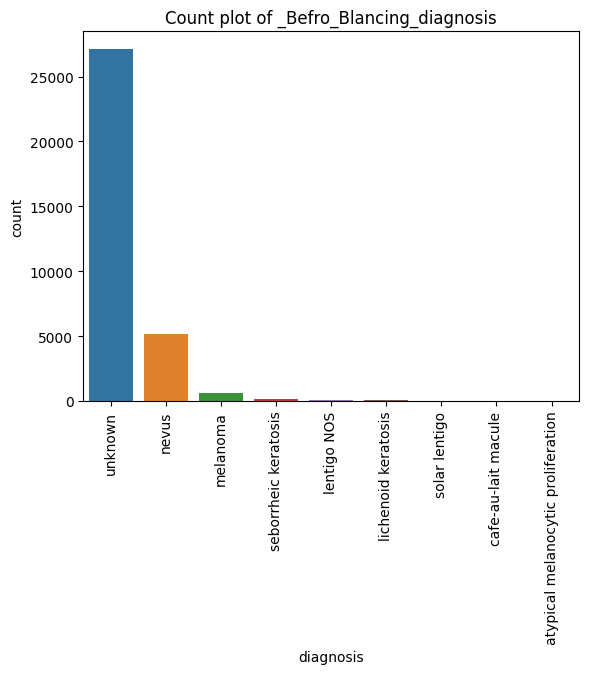

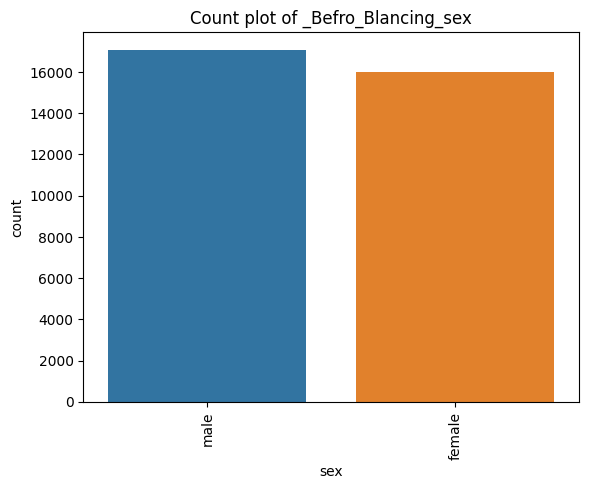

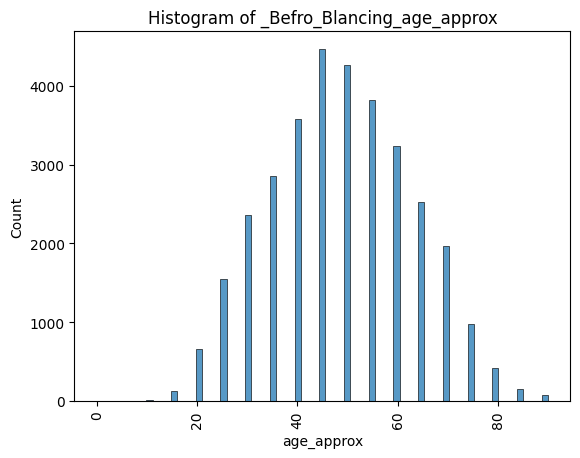

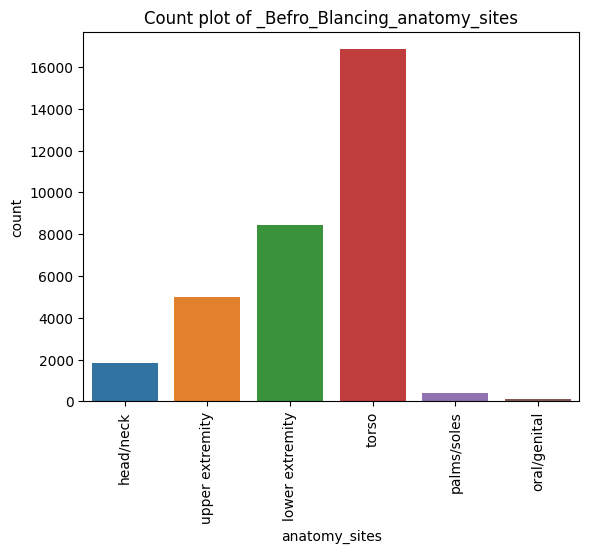

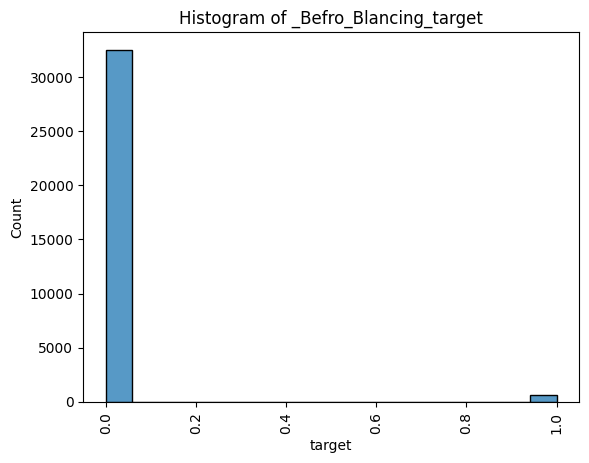

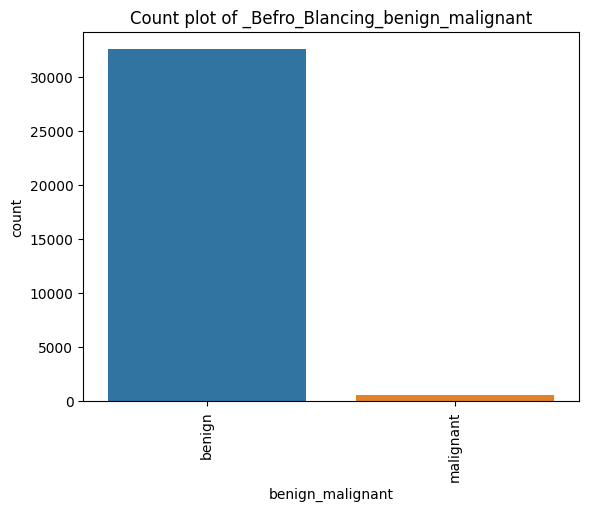

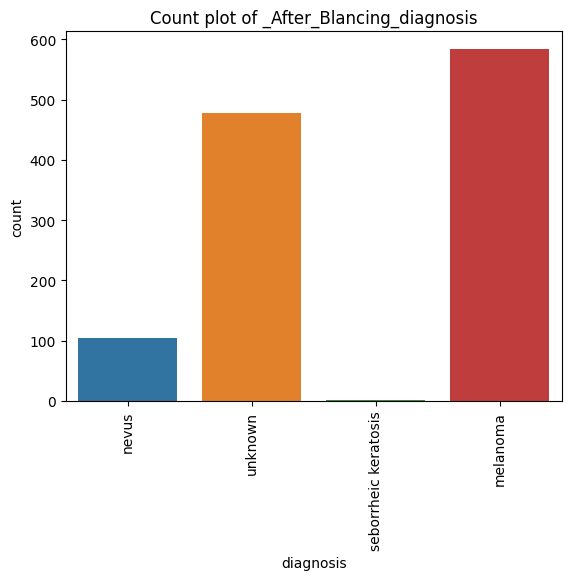

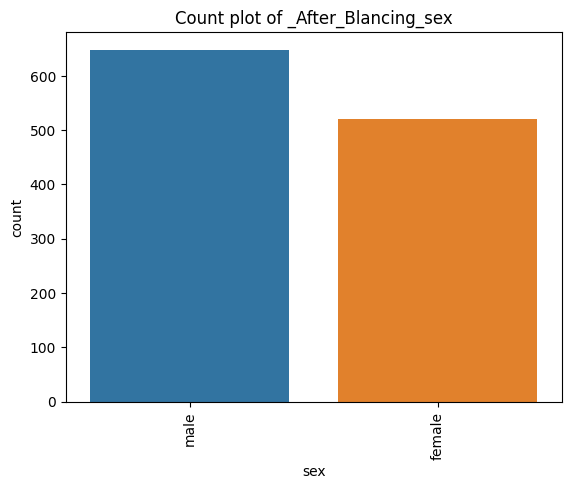

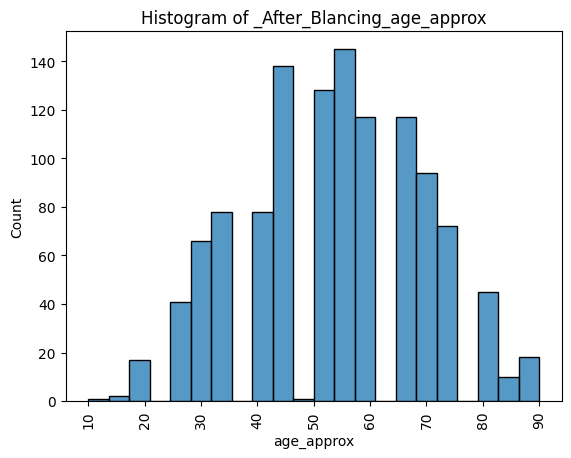

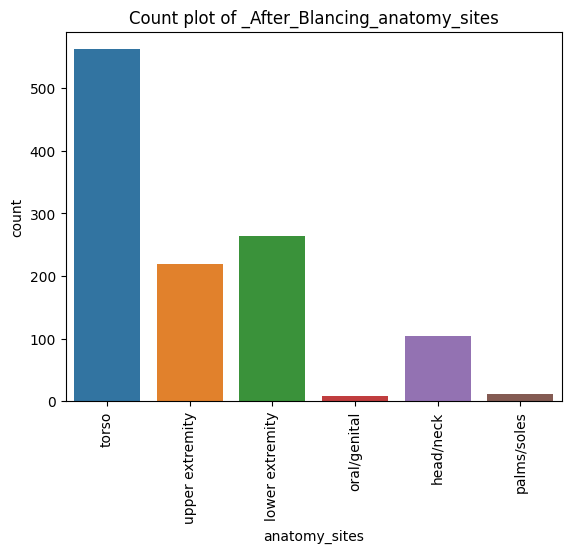

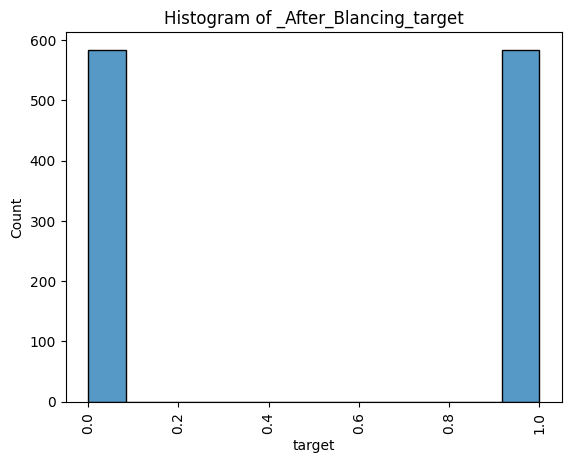

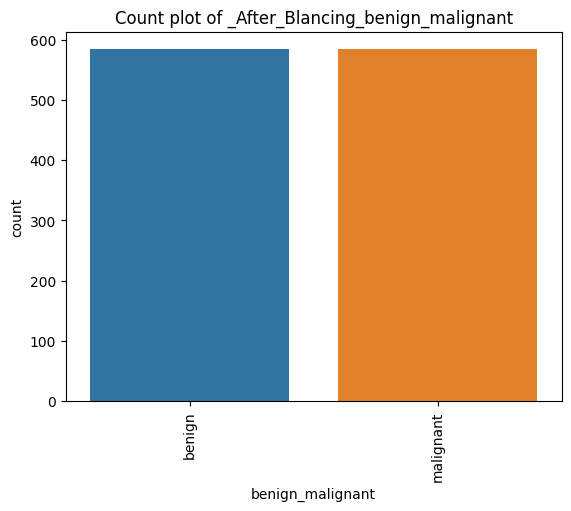

In [9]:
# Define row CSV file name and path

# Current directory
current_dir = os.getcwd()
# print('-------------------')
# print(current_dir)

# Parent directory
parent_dir = os.path.dirname(current_dir)
# print(parent_dir)


Csv_path_Name= 'melanoma-classification_data/'

Train_File_name_pre = 'train_pre.csv'
Train_File_name_post = 'train_post.csv'

# Test_File_name_pre = 'test_pre.csv'
# Test_File_name_post = 'test_post.csv'

Image_File_Path_pre_train = os.path.join(current_dir, 'Images\Pre_Images\Train')
Image_File_Path_post_train = os.path.join(current_dir, 'Images\Post_Images\Train')

# Image_File_Path_pre_test = os.path.join(current_dir, 'Images\Pre_Images\Test')
# Image_File_Path_post_test = os.path.join(current_dir, 'Images\\Post_Images\Test')

Org_csv_file = os.path.join(Csv_path_Name, Train_File_name_pre)
Post_scv_file = os.path.join(Csv_path_Name, Train_File_name_post)

# test_csv_file = os.path.join(Csv_path_Name, Test_File_name_pre)

Train_cleand_csv_File = 'Blanced.csv'
Blanced_csv_file = os.path.join(Csv_path_Name, Train_cleand_csv_File)
Test_cleand_csv_File = ''

# print(Org_csv_file)
# print(current_dir)
df_org  = pd.read_csv(Org_csv_file)

df_org.rename(columns={"anatom_site_general_challenge": "anatomy_sites"}, inplace=True) # rename column name
df_new = df_org.copy()

featuresList = ['benign_malignant']
Blancer = BlanceDataste(df_new,Blanced_csv_file,featuresList)
Blancer.process_Data()



df_Blanced  = pd.read_csv(Blanced_csv_file)
DF_ComparisonX = DF_Comparison(df_new, df_Blanced)
DF_ComparisonX.report()

cleaner_1 = DataCleaner(df_new, 'Befro_Blancing')

cleaner_1.visualize('diagnosis')
cleaner_1.visualize('sex')
cleaner_1.visualize('age_approx')
cleaner_1.visualize('anatomy_sites')
cleaner_1.visualize('target')
cleaner_1.visualize('benign_malignant')

cleaner_2 = DataCleaner(df_Blanced, 'After_Blancing')

cleaner_2.fill_missing_numeric_With_mean('age_approx', 'diagnosis')
cleaner_2.fill_missing_Category_values('anatomy_sites', 'diagnosis')
cleaner_2.fill_missing_Category_values('sex', 'diagnosis')


cleaner_2.visualize('diagnosis')
cleaner_2.visualize('sex')
cleaner_2.visualize('age_approx')
cleaner_2.visualize('anatomy_sites')
cleaner_2.visualize('target')
cleaner_2.visualize('benign_malignant')
cleaner_2.report_and_recommend()


Write_Readme_file()

# print(df_org.head(5))
# print(df_org.describe())
# print(df_org.info())

# # # Remove currupt Image files
# processor = ImageProcessor(Image_File_Path_pre_train , df_org , 'corrupt_files', Post_scv_file)
# processor.process_images()

# df_new = processor.df


# print(df_new.head(5))
# print(df_org.describe())
# print(df_org.info())


#Blance Data stes

# add semple Images befor resizing to README


# add semple Images befor resizing to README











In [10]:
# class DF_Comparison:
#     def __init__(self, df1, df2):
#         self.df1 = df1
#         self.df2 = df2
#         self.outputfile = "output.md"

       
#     def report(self):

#         with open(self.outputfile , 'w'):
#              pass

#         self.print_info(self.df1,"\n ## DataFrame info befor process :")
#         self.print_Missing_values(self.df1,"\n ## Missing values befor & aftre  process :")
             
#         # print("\nUnique values df1 - df2:")
#         title = "\n ## Unique values befor & aftre  process :"
#         self.print_unique_values(title)

#         self.print_value_count("\n ## Value counts befor & aftre  process :")
#         title = "\n ## Descriptive statistics befor and after the process:"



#         # Getting the description of both DataFrames
#         desc_df1 = self.df1.describe()
#         desc_df2 = self.df2.describe()

#         # Combine the two descriptions into one DataFrame
#         combined_desc = pd.concat([desc_df1, desc_df2], axis=1)

#         markdown_str = combined_desc.to_markdown()

#         with FileWriter(self.outputfile ) as writer:
#             writer.append_to_file(title)
#             writer.append_to_file(markdown_str)
#             writer.append_to_file('\n')

      

        
#     def print_info(self,df,title):

        
#         # Capture df.info() output in a string
#         buf = io.StringIO()
#         df.info(buf=buf)
#         info_str = buf.getvalue()

#         # Create a summary DataFrame
#         info_list = info_str.split('\n')[5:-3]  # Remove first and last two lines
#         info_data = [line.split() for line in info_list]  # Split each line into list of words
#         # Create dataframe from info_data
#         info_df = pd.DataFrame(info_data, columns=['index', 'Name', 'Count', 'Non-Null','Dtype'])

#         # Print the summary DataFrame in markdown format
#         # print(info_df.to_markdown(index=False))
#         # print("\n")

#         markdown_str = info_df.to_markdown()

#         # Write the markdown string to a text file
#         with FileWriter(self.outfutfile ) as writer:
#             writer.append_to_file(title)
#             writer.append_to_file(markdown_str)
#             writer.append_to_file('\n')
    
    
#     def print_Missing_values(self,df,title):

#         # Get the count of null values in each column
#         null_counts1 = self.df1.isnull().sum()
#         null_counts2 = self.df2.isnull().sum()
#         null_counts = pd.DataFrame({'Befor':null_counts1,'After':null_counts2})
        
#         with FileWriter(self.outfutfile ) as writer:
#              writer.append_to_file(title)
#              writer.append_to_file(null_counts.to_markdown())
#              writer.append_to_file('\n')

#     def print_unique_values(self,title):

#         unique_counts1 = self.df1.nunique()
#         unique_counts2 = self.df2.nunique()
#         unique_counts = pd.DataFrame({'Befor':unique_counts1,'After':unique_counts2})

#         #print(unique_counts)    
#         # Write the markdown string to a text file
#         with FileWriter(self.outfutfile ) as writer:
#              writer.append_to_file(title)
#              writer.append_to_file(unique_counts.to_markdown())
#              writer.append_to_file('\n')

#     def print_value_count(self,title):

#         # Create an empty DataFrame to store the results
#         result = pd.DataFrame()
        
#         # Iterate over each column
#         for column in self.df1.columns:

#             if self.df1[column].nunique() > 8:
#                 continue

#             df1_counts = self.df1[column].value_counts()
#             df2_counts = self.df2[column].value_counts()

#             # Combine the two Series into a DataFrame
#             temp_df = pd.concat([df1_counts, df2_counts], axis=1, keys=['DF1', 'DF2'])

#             # Add the column name to the DataFrame
#             temp_df['Column'] = column

#             # Append the temporary DataFrame to the result DataFrame
            
#             result = pd.concat([result, temp_df])
            

#         # Reset the index of the result DataFrame
#         result.reset_index(inplace=True)

#         # Rename the columns for clarity
#         result.columns = ['Value', 'Count Befor', 'Count After', 'Column']

#         # Rearrange the columns
#         result = result[['Column', 'Value', 'Count Befor', 'Count After']]

#         with FileWriter(self.outfutfile ) as writer:
#              writer.append_to_file(title)
#              writer.append_to_file(result.to_markdown())
#              writer.append_to_file('\n')

        


In [11]:
# # Define row CSV file name and path
# File_name = 'train.csv'
# Path_Name = 'Data/Row_data(pre)'
# Image_File_Path = 'TempImages\jpeg\Train'


# row_csv_file = os.path.join(Path_Name, File_name)

# # Current directory
# current_dir = os.getcwd()
# print(current_dir)

# # Parent directory
# parent_dir = os.path.dirname(current_dir)
# print(parent_dir)

# Image_File_Path = os.path.join(parent_dir, Image_File_Path)


# df_org  = pd.read_csv(row_csv_file)
# df_org.rename(columns={"anatom_site_general_challenge": "anatom
# .-0`_sites"}, inplace=True) # rename column name
# df_new = df_org.copy()
# print(df_new.head(5))

# # assuming df is your DataFrame and 'class_column' is your class or category column
# groups = df_new.groupby('benign_malignant')
# print(groups.count())

# # Find the smallest count
# min_count = df_new['benign_malignant'].value_counts().min()

# # Sample min_count rows from each category
# balanced_df = df_new.groupby('benign_malignant').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# # print(balanced_df.count())
# # print(balanced_df.head(5))
# #

# # processor = ImageProcessor(Image_File_Path,row_csv_file, 'corrupt_files', 'new_images.csv')
# # processor.process_images()
# balanced_df_new = balanced_df.copy()

# DF_Comparison_1 = DF_Comparison(balanced_df, balanced_df_new)

# cleaner_1 = DataCleaner(balanced_df)
# cleaner_2 = DataCleaner(balanced_df_new)


# cleaner_1.report_and_recommend()
# cleaner_2.fill_missing_numeric_With_mean('age_approx', 'diagnosis')
# cleaner_2.fill_missing_Category_values('anatomy_sites', 'diagnosis')
# cleaner_2.fill_missing_Category_values('sex', 'diagnosis')
# cleaner_2.report_and_recommend()

# print(balanced_df_new.head(5))
# # DF_Comparison_1.report()

# # #updated with out error

# # #cleaner.report()
# cleaner_2.visualize('diagnosis')
# cleaner_2.visualize('sex')
# cleaner_2.visualize('age_approx')
# cleaner_2.visualize('anatomy_sites')
# cleaner_2.visualize('target')
# cleaner_2.visualize('benign_malignant')

# # Write_Readme_file()